#### COMP90024 Cluster and Cloud Computing

# Group Project - Sentiment and Topic Analysis

---

In [11]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ankitadhar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
#import required packages
import re
import json
import string
from pprint import pprint
import pandas as pd
import numpy as np
from functools import reduce

#import NLP packages
import nltk
from nltk.corpus import stopwords as stpwrd
from nltk.tokenize import TweetTokenizer
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_selection import f_regression
from empath import Empath
from gensim import corpora
from gensim.models import TfidfModel
from gensim.models.ldamodel import LdaModel

#Download required datasets
#nltk.download("stopwords")
#nltk.download("vader_lexicon")
#nltk.download("averaged_perceptron_tagger")

#Import plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

#Import geometry packages
from geojson import Feature, FeatureCollection
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

#ignore FutureWarnings
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

### ETL

#### (i) Import data

In [9]:
#define function for data extraction
def extract(file_path, col_index, col_name):
    """
    Function extracts data from provided file with standard geoJSON format
    
    Keyword Arguments:
    file_path -- path of file to extract
    col_index -- index of features to extract (should be in required order)
    col_name -- names of features (should follow col_index order)
    
    Returns: dataframe
    """
    #lga_code must be provided as a feature
    if "lga_code" not in col_name:
        return "ERROR - lga_code needs to be provided as feature"
    
    df = pd.read_json(file_path, lines = True)["features"]
    df = pd.json_normalize(df[0]).iloc[:, col_index]
    df.columns = col_name
    
    #extracts information only for LGAs within VIC
    df["lga_code"] = pd.to_numeric(df["lga_code"])
    df = df[df["lga_code"].between(20000, 29999, inclusive = True)]
    
    return df

In [353]:
#Import requried data
twitter = pd.read_json("victoriaTweet.json")

#Extract AURIN datasets
aurin = {}
filename = {"worklife": "AURIN_datasets/adequate_worklife.json",
            "sleep": "AURIN_datasets/inadequate_sleep.json",
            "lacktime": "AURIN_datasets/lacking_time.json",
            "pressure": "AURIN_datasets/time_pressure.json"}

for name, dataset in filename.items():
    col_index = np.r_[7,4,3,5,8]
    col_name = ["lga_code", "lga_name", name, "ci_high", "ci_low"]
    aurin[name] = extract(dataset, col_index, col_name)

aurin["income"] = extract("AURIN_datasets/personal_income.json", np.r_[3,4,2],
                          ["lga_code", "lga_name", "median_income"])
aurin["age"] = extract("AURIN_datasets/median_age.json", np.r_[7,4,5],
                       ["lga_code", "lga_name", "median_age"])
aurin["profile"] = extract("AURIN_datasets/lga_profile.json", np.r_[5,4,2,3,6:13],
                           ["lga_code", "lga_name", "unemploy_rate", "physical_activity", "not_yr12", "offences",
                           "good_facilities", "distress", "food_insecurity", "higher_edu", "poor_health"])

#Extract LGA polygons
aurin["lga_polygon"] = extract("AURIN_datasets/lga_regions.json", np.r_[4,7,3],
                               ["lga_code", "lga_name", "lga_polygon"])

#Merge extracted datasets into one df
data = reduce(lambda x,y: pd.merge(x, y, on = "lga_code", how = "left"),
              [aurin["worklife"][["lga_code", "lga_name", "worklife"]], aurin["sleep"][["lga_code", "sleep"]],
               aurin["lacktime"][["lga_code", "lacktime"]], aurin["pressure"][["lga_code", "pressure"]],
               aurin["income"][["lga_code", "median_income"]], aurin["age"][["lga_code", "median_age"]],
               aurin["profile"][["lga_code", "unemploy_rate", "physical_activity", "not_yr12", "offences",
                                 "good_facilities", "distress", "food_insecurity", "higher_edu", "poor_health"]],
               aurin["lga_polygon"][["lga_code", "lga_polygon"]]])

data

,lga_code,lga_name,worklife,sleep,lacktime,pressure,median_income,median_age,unemploy_rate,physical_activity,not_yr12,offences,good_facilities,distress,food_insecurity,higher_edu,poor_health,lga_polygon
0,25490,Moyne (S),48.0,26.4,24.3,37.5,34349.0,42,3.190043,24.2216,0.663386,32.458187,0.7306,8.6583,0.046,0.284037,11.9908,"[[[[142.729277344, -38.52699431850001], [142.7..."
1,20110,Alpine (S),44.6,26.4,23.2,28.4,32440.0,48,4.903835,26.0961,0.654545,30.160726,0.7771,9.1857,0.074,0.292141,18.9998,"[[[[147.39225776, -37.04559268450001], [147.39..."
2,20260,Ararat (RC),48.2,28.7,21.2,36.0,35984.0,44,5.724736,28.1661,0.690461,72.833477,0.8208,9.9339,0.126,0.249561,21.1998,"[[[[143.241437568, -37.402936002000004], [143...."
3,20570,Ballarat (C),50.7,28.8,22.1,39.7,40000.0,37,7.106465,24.4215,0.595153,87.259496,0.8339,13.5170,0.073,0.368236,19.5012,"[[[[143.950689344, -37.5596146295], [143.95069..."
4,20660,Banyule (C),51.0,34.3,31.1,42.8,46525.0,39,3.044748,27.0449,0.462967,51.873579,0.9169,12.4427,0.047,0.485552,15.8184,"[[[[145.14370348799997, -37.682624163499995], ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,27170,Wodonga (RC),55.5,30.8,23.8,39.5,41806.0,35,6.563044,25.3996,0.631019,74.013230,0.9130,9.7782,0.064,0.261575,18.7087,"[[[[146.997468192, -36.2102765035], [146.99780..."
75,27260,Wyndham (C),49.5,36.2,32.9,47.4,46419.0,32,6.936733,28.6707,0.553292,70.025404,0.8462,8.6856,0.059,0.318634,20.0879,"[[[[144.80450265599998, -37.894350262500005], ..."
76,27350,Yarra (C),53.2,27.9,25.4,53.8,50000.0,34,4.169967,24.8838,0.256398,125.724067,0.9019,11.8713,0.078,0.727226,17.5358,"[[[[145.04527430399997, -37.7843216235], [145...."
77,27450,Yarra Ranges (S),53.6,28.2,29.9,42.8,41205.0,39,3.786415,26.2953,0.581624,39.550667,0.8139,11.7355,0.063,0.300570,18.8615,"[[[[146.192502112, -37.581130554999994], [146...."


#### (ii) Tokenize tweets

In [59]:
#Tokenize tweet text
def tokenize(df, stopwords):
    """
    Tokenizes tweet text, i.e. separates tweet text into individual tokens, while replacing 
    individual urls/numbers with "<url>" and "<number>" tags respectively and removing stopwords
    Tokenization performed using nltk TweetTokenizer() 
    
    Keyword Arguments:
    df -- dataframe of tweets
    stopwords -- list of stopwords to be removed during tokenization
    
    Returns: dataframe
    """
    tokenized_text = []
    tweet_tknzr = TweetTokenizer(preserve_case = False, reduce_len = True, strip_handles = True)
    for tweet in df["text"]:
        tokens = []
        for token in tweet_tknzr.tokenize(tweet):
            if re.search("http\S+", token): #replace urls with <url> tag
                tokens.append("<url>")
            elif re.search("^\d+", token): #replace any number with <number> tag
                tokens.append("<number>")
            elif token.lower() not in stopwords: #remove stopwords
                tokens.append(token)
        tokenized_text.append(tokens)

    df["tokenized_text"] = tokenized_text
    
    return df

In [363]:
#Peform tokenization of tweets
stopwords = stpwrd.words("english") + list(string.punctuation) + ["“", "”", "’", "...", "..", "…"]
twitter = tokenize(twitter, stopwords)
twitter["tokenized_text"] = twitter["tokenized_text"].apply(lambda tokens: " ".join(tokens))

,text,coordinates_lat,coordinates_lng,lga_code,tokenized_text,sentiment
0,DSS 43 receiving data from STEREO A at 0.7Mb/s...,-35.401389,148.981667,NaN,dss <number> receiving data stereo <number> mb...,0.0000
1,Captain cook's memorial jet. \n\n#canberra #to...,-35.308100,149.124000,NaN,captain cook's memorial jet #canberra #tourist...,0.0000
2,This #job might be a great fit for you: Govern...,-35.282000,149.128684,NaN,#job might great fit government health devops ...,0.7650
3,Someone said #Friday ..? 🧐🍿\n..\n#nofilter #ye...,-35.315500,149.151000,NaN,someone said #friday 🧐 🍿 #nofilter #yesfilter ...,0.0000
4,Libs having trouble organising #libspill on ti...,-35.308056,149.124444,NaN,libs trouble organising #libspill time past hi...,0.0516
...,...,...,...,...,...,...
719623,There maybe only a handful of venues I feel in...,-35.277991,149.130293,NaN,maybe handful venues feel inclined visit right...,0.0000
719624,Good morning BM! @ Yarramundi Reach https://t....,-35.291969,149.081059,NaN,good morning bm yarramundi reach <url>,0.4588
719625,DSS 34 carrier lock on MMS 2\nFrequency: 2.281...,-35.401389,148.981667,NaN,dss <number> carrier lock mms <number> frequen...,0.4939
719626,Fruity. - Drinking a Golden Ale by @hawthornbr...,-35.435600,149.113000,NaN,fruity drinking golden ale calwell — <url>,0.0000


### Sentiment Analysis

#### (i) Perform sentiment analysis

In [ ]:
#Perform sentiment analysis using VADER
sid = SentimentIntensityAnalyzer()
#extract only compound sentiment polarity score
twitter["sentiment"] = twitter["tokenized_text"].apply(lambda text: sid.polarity_scores(text)["compound"])

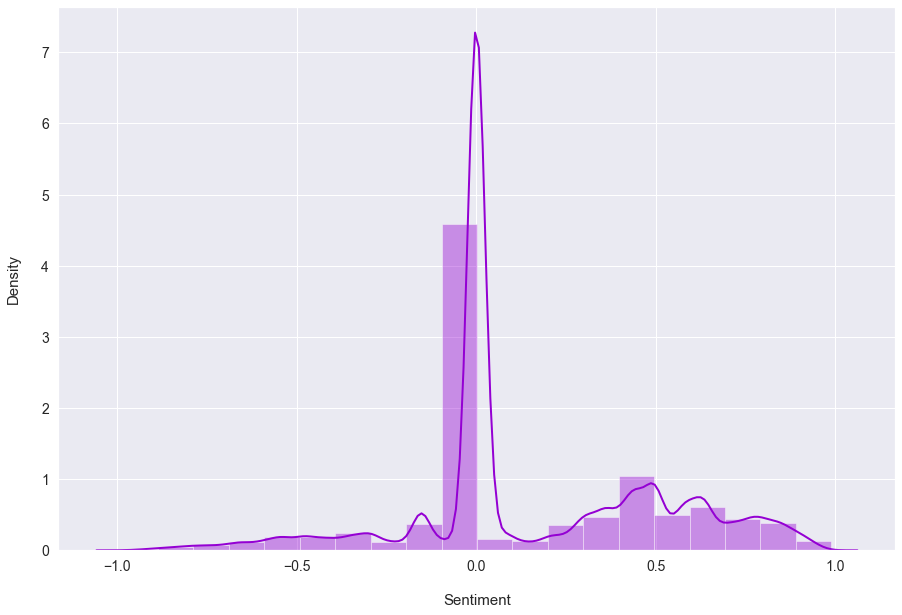

In [394]:
#Plot distribution of sentiments scores
fig, ax = plt.subplots(figsize = (15, 10))
n_bins = 20
sns.distplot(twitter["sentiment"], bins = n_bins, color = "darkviolet", kde_kws = {"linewidth": 2})

ax.tick_params(axis = "both", labelsize = 14)
ax.set_xlabel("Sentiment", fontsize = 15, labelpad = 20)
ax.set_ylabel("Density", fontsize = 15, labelpad = 20)

plt.savefig("sentiment.jpg")
#plt.show()

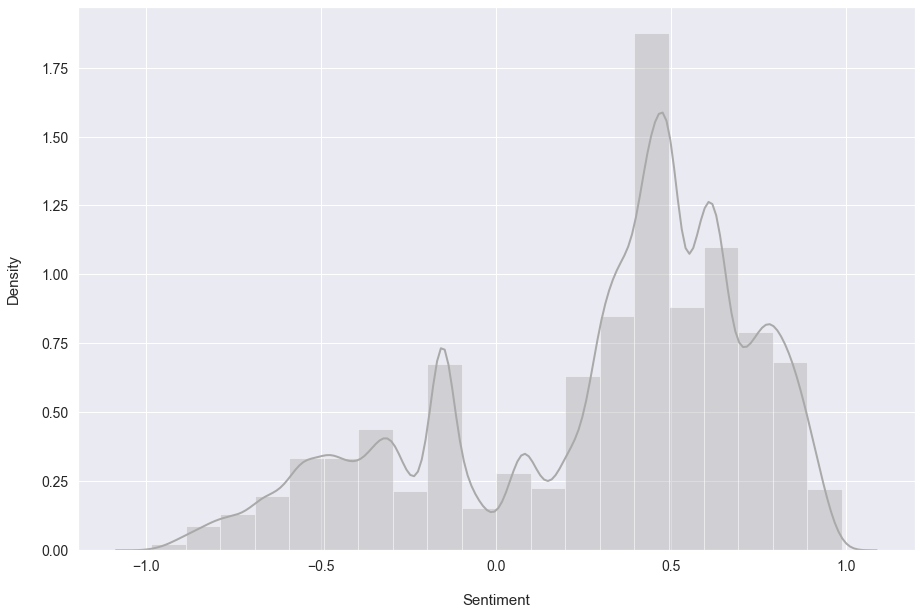

In [395]:
#Plot distribution of sentiments scores (without sentiment = 0) 
fig, ax = plt.subplots(figsize = (15, 10))
sns.distplot(twitter[twitter["sentiment"] != 0]["sentiment"],
             bins = n_bins, color = "darkgrey", kde_kws = {"linewidth": 2})

ax.tick_params(axis = "both", labelsize = 14)
ax.set_xlabel("Sentiment", fontsize = 15, labelpad = 20)
ax.set_ylabel("Density", fontsize = 15, labelpad = 20)

plt.savefig("sentiment_no0.jpg")
#plt.show()

#### (ii) Understand correlation and significance between features and sentiment

In [398]:
#Descriptive statistics for all features
round(data.describe(), 2)

,lga_code,worklife,sleep,lacktime,pressure,median_income,median_age,unemploy_rate,physical_activity,not_yr12,offences,good_facilities,distress,food_insecurity,higher_edu,poor_health,sentiment
count,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,79.00,36.00
mean,24030.63,50.56,30.65,25.98,39.25,39551.33,40.76,4.94,25.99,0.59,59.90,0.79,11.43,0.06,0.35,18.05,0.17
std,2165.42,6.60,4.90,3.69,5.02,5308.69,5.19,1.53,4.02,0.14,32.11,0.11,2.76,0.02,0.14,3.30,0.03
min,20110.00,37.60,18.80,17.80,26.50,29999.00,29.00,1.70,18.08,0.16,21.53,0.49,5.14,0.02,0.20,8.97,0.12
25%,22210.00,46.20,27.75,23.45,36.80,35798.50,38.00,3.82,23.22,0.52,40.25,0.74,9.81,0.04,0.26,15.99,0.15
50%,24210.00,50.00,30.10,25.40,39.00,39435.00,39.00,4.93,26.10,0.63,55.15,0.80,11.06,0.06,0.29,17.51,0.17
75%,25945.00,54.80,33.50,29.05,42.75,43284.50,44.50,5.89,28.83,0.69,72.23,0.88,12.82,0.08,0.39,20.37,0.19
max,27630.00,69.50,44.10,36.20,53.80,52569.00,54.00,8.43,35.26,0.76,273.14,0.96,19.20,0.13,0.73,25.53,0.25


<Figure size 1008x864 with 0 Axes>

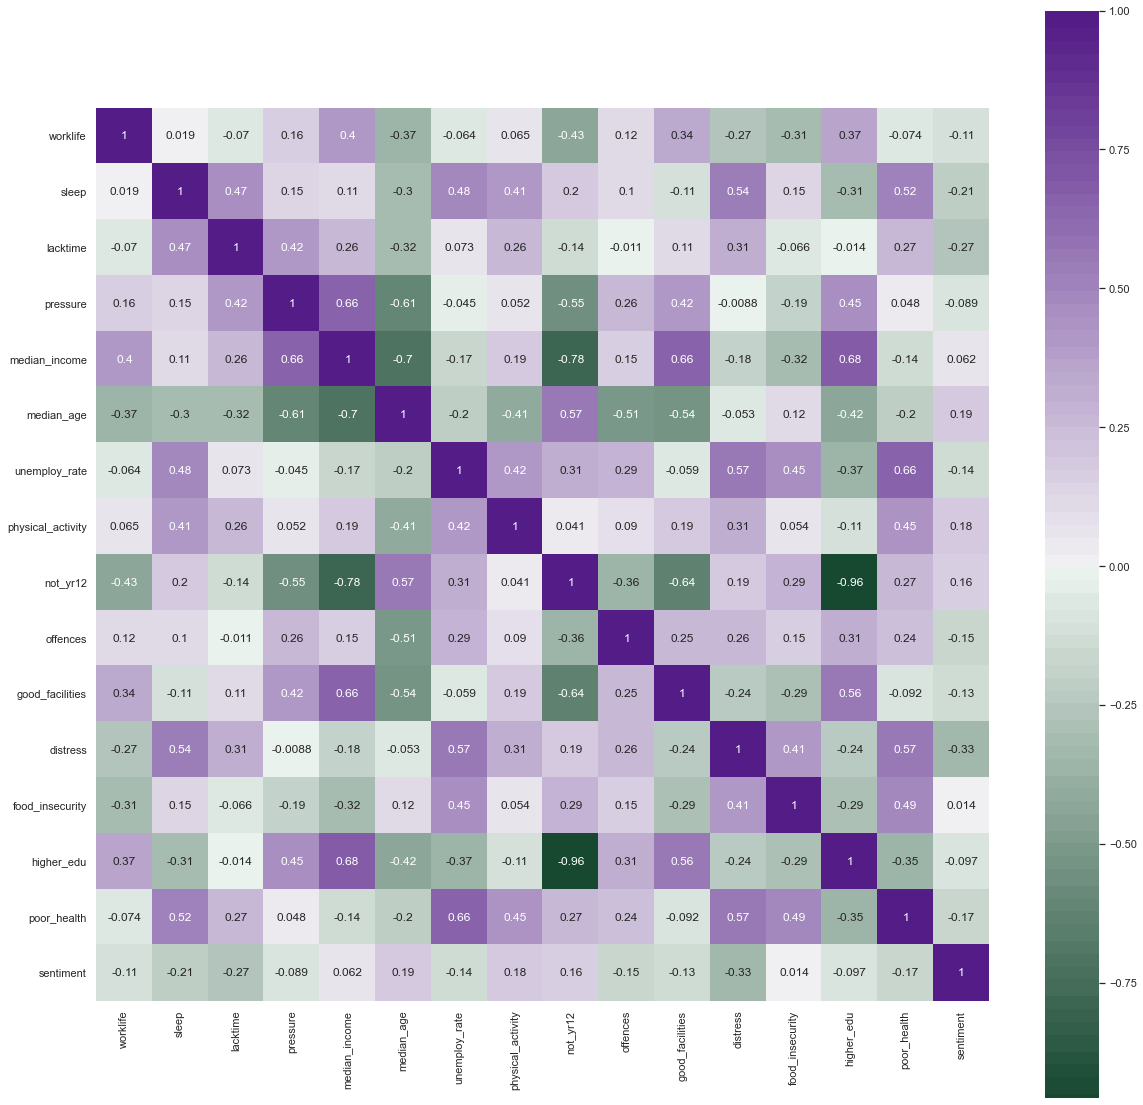

In [390]:
#Plot heatmap of correlations between features
plt.figure(figsize = (14, 12))
plt.subplots(figsize = (20, 20))
ax = sns.heatmap(data.iloc[:, np.r_[2:17, 18]].corr(), square = True, annot = True, center = 0,\
                 cmap = sns.diverging_palette(145, 280, s = 85, l = 25, n = 80))

plt.savefig("heatmap.jpg")

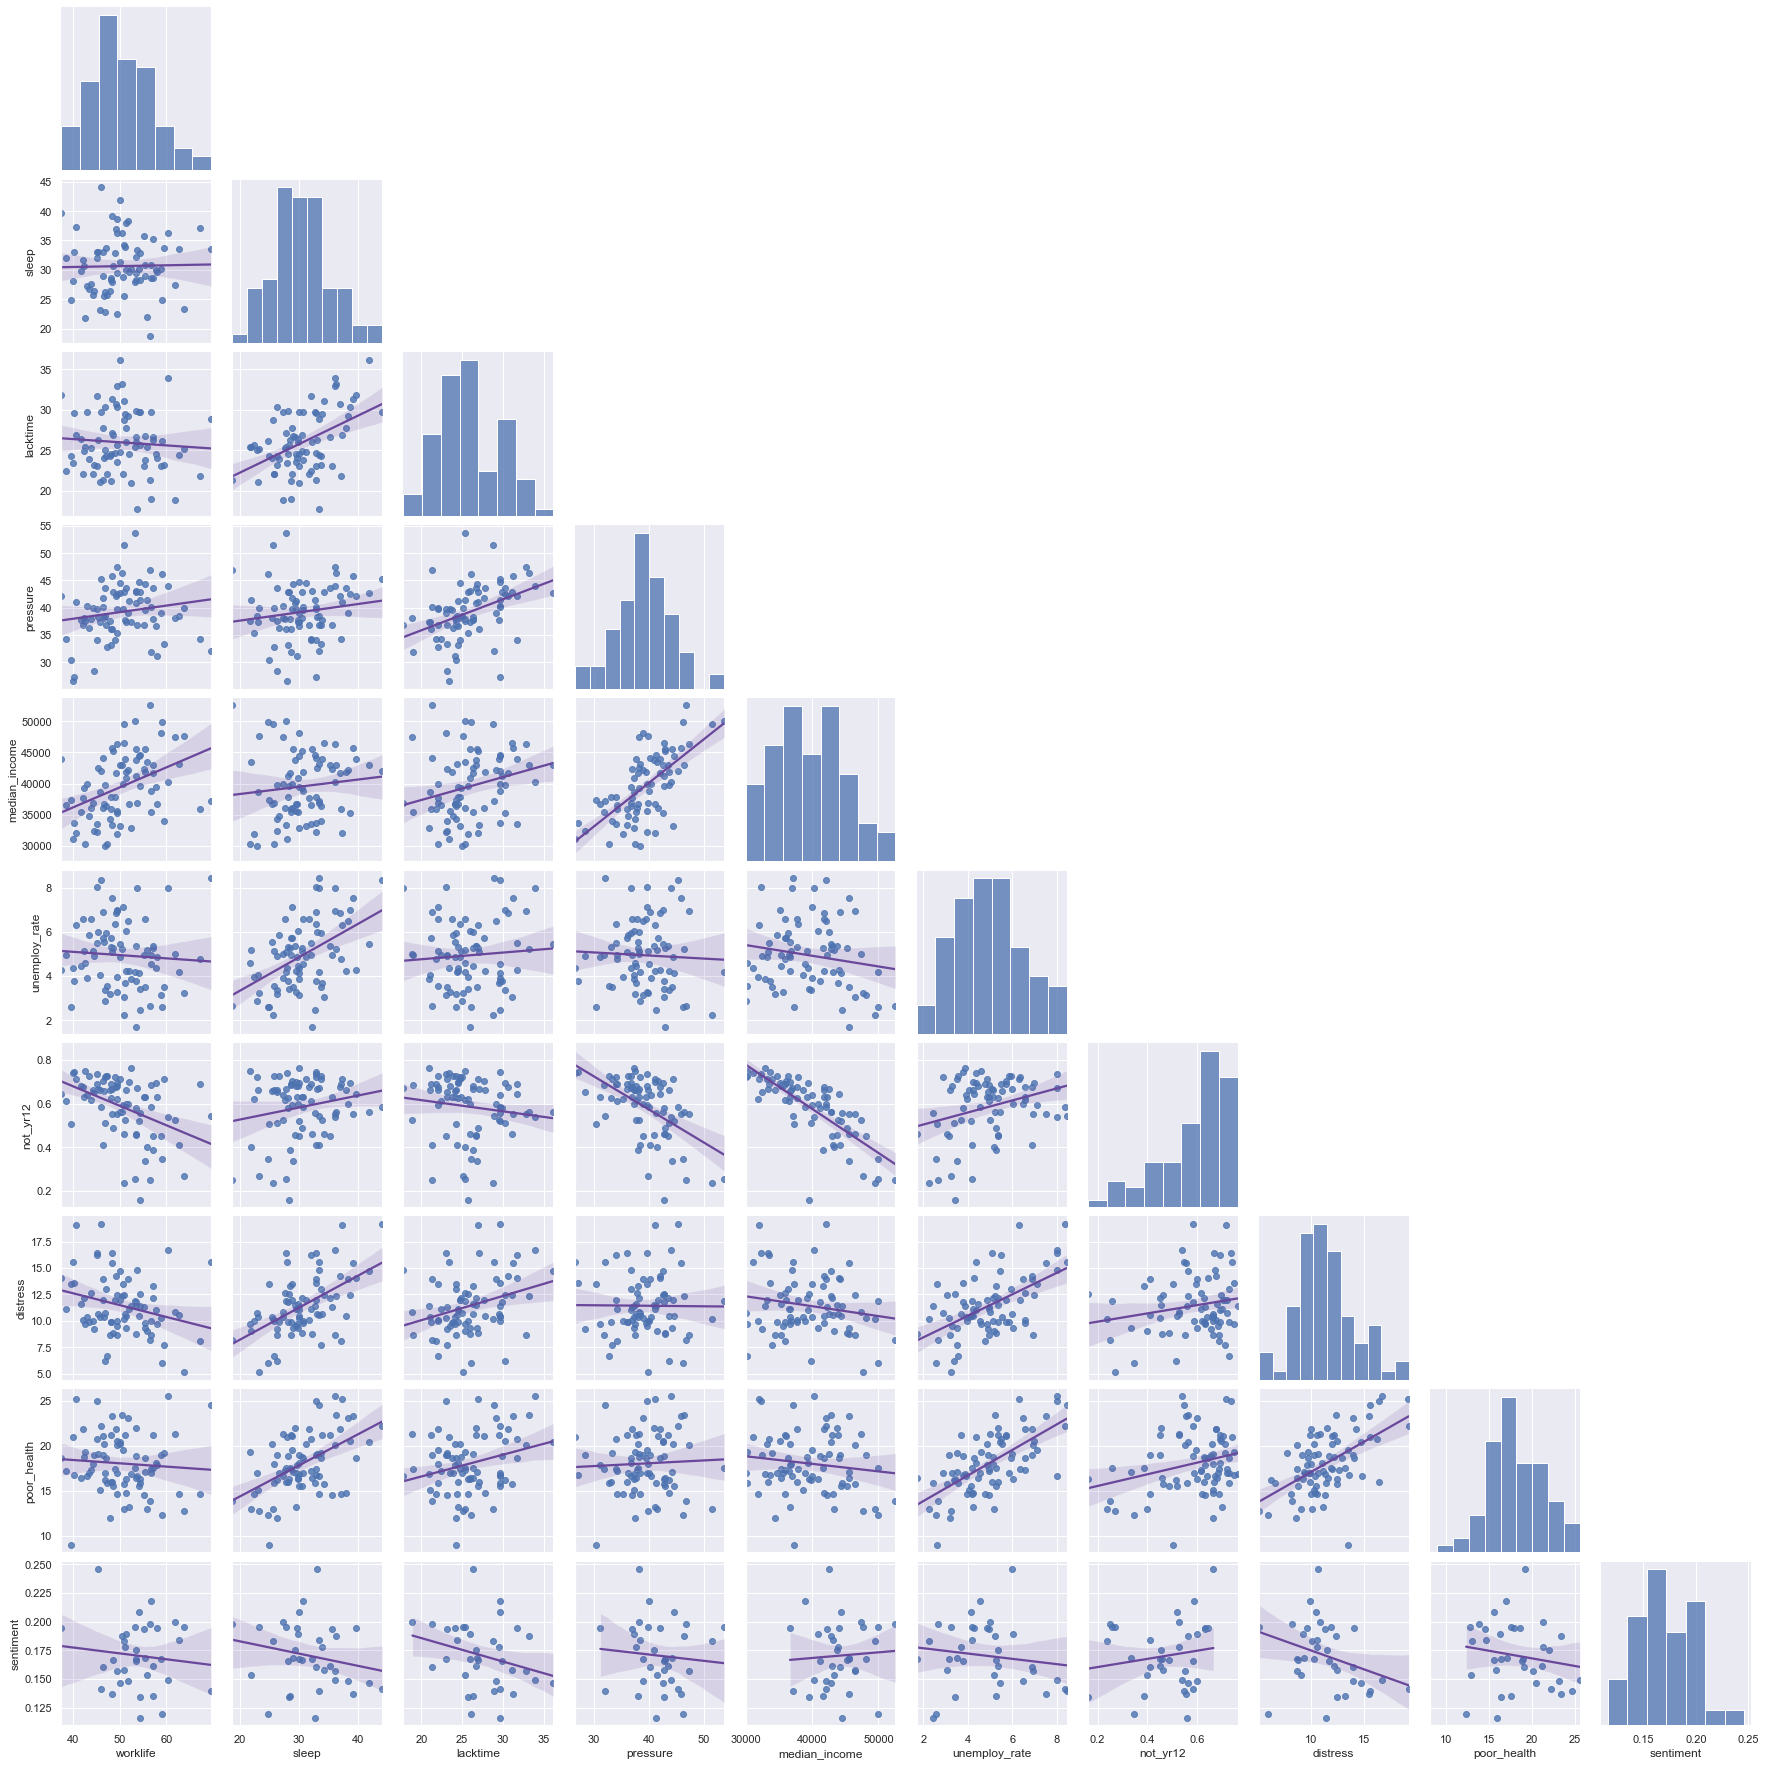

In [391]:
#Pair plots for selected features
sns.pairplot(data.iloc[:, np.r_[2:7,8,10,13,16,18]], kind = "reg",
             plot_kws = {"line_kws": {"color": "#69479b"}}, corner = True)

plt.savefig("pairs.jpg")

In [376]:
#Perform F-test to test null hypothesis
data_dropna = data.dropna()
f_reg = f_regression(data_dropna.iloc[:, 2:17], data_dropna.iloc[:, 18])
print("F-values: ", f_reg[0])
print("p-values: ", f_reg[1])

F-values:  [0.39946413 1.50298098 2.69852974 0.27135872 0.12911418 1.26672729
 0.70114509 1.0919283  0.92479661 0.79355389 0.57517544 4.25427164
 0.00624939 0.32516437 0.97556379]
p-values:  [0.5315934  0.22863711 0.10965896 0.60579816 0.72157436 0.26826388
 0.40824669 0.30341708 0.34300846 0.37928835 0.453435   0.04685769
 0.93745385 0.57226976 0.33027375]


#### (iii) Calculate mean sentiment score per LGA

In [364]:
#Build LGA polygons
lga_polygon = {}
for lga in data.iterrows():
    lga_code = lga[1]["lga_code"]
    polygon = Polygon(lga[1]["lga_polygon"][0][0])
    lga_polygon[lga_code] = polygon
    
#Allocate tweets to individual LGAs
tweet_lga = {}
index = 0
for tweet in twitter.iterrows():
    point = Point(tweet[1]["coordinates_lng"], tweet[1]["coordinates_lat"])
    for code, polygon in lga_polygon.items():
        if polygon.contains(point): #checks if point is within polygon
            tweet_lga[index] = code
            continue
    index += 1

#Calculate mean sentiment score per LGA
twitter["lga_code"] = twitter.index.map(tweet_lga)
lga_meanSent = pd.DataFrame(twitter.groupby("lga_code")["sentiment"].mean().reset_index())
data = pd.merge(data, lga_meanSent, on = "lga_code", how = "outer")
print("LGA w data: ", data["sentiment"].count())

LGA w Data:  36


#### (iv) Export geoJSON for choropleth

In [291]:
#Format data as geoJSON
features = data["lga_polygon"].apply(lambda row: Polygon(row[0][0])).to_dict()
properties = data.fillna("").drop(["lga_polygon"], axis = 1).to_dict("index")

feature_collection = []
for i in range(len(properties)):
    feature_collection.append(Feature(geometry = features[i], properties = properties[i]))

feature_collection = FeatureCollection(feature_collection)
#pprint(feature_collection)

#Export geoJSON as file
with open("choropleth.geojson", "w") as file:
    json.dump(feature_collection, file)

### Topic Analysis

#### (i) Lexical Categorisation

In [ ]:
#Calculate lexical category scores of each tweet
twitter_dropNaN = twitter.dropna().copy()
lexicon = Empath()
twitter["category_scores"] = twitter_dropNaN["tokenized_text"].apply(lambda tweet: 
                                                                     lexicon.analyze(tweet, normalize = True))

In [404]:
#Extract most likely lexical category
def max_category(cat_scores):
    """
    Extracts category with maximum score from empath lexical categoriser outputs
    
    Keyword Arguments:
    cat_scores -- output from empath lexical categoriser (dict of topics and scores)
    
    Returns: empath category with max score
    """
    max_cat = max(cat_scores, key = cat_scores.get)
    
    #where all categories have score 0, supply None
    if (max_cat == "help") and (cat_scores["help"] == 0.0):
        max_cat = None
        
    return max_cat

twitter_dropNaN["max_category"] = twitter_dropNaN["category_scores"].apply(max_category)
#Output list of categories sorted by frequency count
print(twitter_dropNaN.groupby("max_category")["max_category"].count().sort_values(ascending = False))

#Extract top 10 topics/counts to JSON
twitter_dropNaN.groupby("max_category")\
    ["max_category"].count().sort_values(ascending = False).nlargest(10).to_json("top10_topics.json")

max_category
weather             41485
vacation            22532
attractive          14334
domestic_work       12964
optimism            12380
                    ...  
joy                    21
white_collar_job       21
sound                  21
disappointment          4
anger                   1
Name: max_category, Length: 194, dtype: int64


#### (ii) Latent Dirichlet Allocation (LDA)

In [412]:
#Lemmatize tokenized tweet text
def lemmatize(text):
    """
    Lemmatizes tokenized tweet text, e.g. walking, walked, walks all return lemma walk
    Lemmatisation requires part-of-speech (POS) tag to return correct inflected form
    
    Keyword Arguments:
    text -- output from tokenized tweet text
    
    Returns: list of lemmas
    """
    text_lemma = []
    text = list(filter(None, text.split(" ")))
    for word, tag in pos_tag(text): #perform POS tagging using Penn Treebank corpus
        tag = tag[0].lower()
        #convert Penn Treebank tags to WordNet tags
        if tag.startswith("j"):
            tag = wordnet.ADJ
        elif tag.startswith("v"):
            tag = wordnet.VERB
        elif tag.startswith("n"):
            tag = wordnet.NOUN
        elif tag.startswith("r"):
            tag = wordnet.ADV
        else:
            tag = None

        lemma = nltk.stem.WordNetLemmatizer().lemmatize(word, pos = tag) if tag else word
        text_lemma.append(lemma)

    return text_lemma

twitter_dropNaN["lemmatize"] = twitter_dropNaN["tokenized_text"].apply(lemmatize)
twitter_dropNaN

,text,coordinates_lat,coordinates_lng,lga_code,tokenized_text,sentiment,lemmatize
8393,This one is as big as it looks. Have to get up...,-37.748800,144.966900,25250.0,one big looks get tomorrow tighten speakers hi...,0.0000,"[one, big, look, get, tomorrow, tighten, speak..."
8394,Rare for me to be on this side of a camera. Th...,-38.183300,145.083000,25340.0,rare side camera thanks making forget insecuri...,-0.2023,"[rare, side, camera, thanks, make, forget, ins..."
8395,I hope this sort of info is being more broadly...,-37.861389,144.974297,25900.0,hope sort info broadly disseminated twitter ac...,0.4404,"[hope, sort, info, broadly, disseminate, twitt..."
8398,New studio tool 💕😊 Can’t believe how good ever...,-37.821500,145.003200,27350.0,new studio tool 💕 😊 believe good everything so...,0.4404,"[new, studio, tool, 💕, 😊, believe, good, every..."
8401,Just posted a photo @ Gladstone Park https://t...,-37.690000,144.894000,23270.0,posted photo gladstone park <url>,0.0000,"[post, photo, gladstone, park, <url>]"
...,...,...,...,...,...,...,...
717729,#railwaytracks #macaulaytrainstation #thingspl...,-37.794600,144.936200,25060.0,#railwaytracks #macaulaytrainstation #thingspl...,0.0000,"[#railwaytracks, #macaulaytrainstation, #thing..."
717730,To celebrate Neighbourhood House Week staff fr...,-37.821620,144.892808,24330.0,celebrate neighbourhood house week staff neigh...,0.5719,"[celebrate, neighbourhood, house, week, staff,..."
717732,Hey all! Remember tonight from 7:30-10:30pm fo...,-37.773299,144.829636,21180.0,hey remember tonight <number> <number> pm <num...,0.0000,"[hey, remember, tonight, <number>, <number>, p..."
717733,I don’t know anywhere else I’d rather be than ...,-37.579880,145.413350,27450.0,know anywhere else rather cellar door today op...,0.0000,"[know, anywhere, else, rather, cellar, door, t..."


In [424]:
#Create term dictionary from tokenized text
num_topics = 10
dictionary = corpora.Dictionary(twitter_dropNaN["lemmatize"])

#Create document-term matrix, i.e. bag-of-word (BOW) corpus
bow_corpus = [dictionary.doc2bow(text) for text in twitter_dropNaN["lemmatize"]] #(word#, count)

#Create TF-IDF corpus
tfidf = TfidfModel(bow_corpus)
tfidf_corpus = tfidf[bow_corpus] #(word#, tf-idf)

In [425]:
#Train LDA model w BOW corpus
lda_bow = LdaModel(bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 20)

In [426]:
#Train LDA model w TF-IDF corpus
lda_tfidf = LdaModel(tfidf_corpus, num_topics = num_topics, id2word = dictionary, passes = 20)

In [436]:
#Obtain top topics from trained LDA model
bow_topTopics = lda_bow.top_topics(bow_corpus)
tfidf_topTopics = lda_tfidf.top_topics(tfidf_corpus)

#LDA BOW Output
#UMass coherence (log of probabilities) = log[(D(Wi, Wj) + epsilon) / D(Wi)]
#Average topic coherence - sum of topic coherences of all topics, divided by the number of topics
avg_topicCoherence_bow = sum([topic[1] for topic in bow_topTopics]) / num_topics
print("Average Topic Coherence BOW: ", avg_topicCoherence_bow, "\n")

for index, topic in lda_bow.print_topics(-1):
    print('Topic: {} \nWord: {}\n'.format(index, topic))

print("-"*50)
    
#LDA TF-IDF Output
avg_topicCoherence_tfidf = sum([topic[1] for topic in tfidf_topTopics]) / num_topics
print("Average Topic Coherence TF-IDF: ", avg_topicCoherence_tfidf, "\n")

for index, topic in lda_tfidf.print_topics(-1):
    print('Topic: {} \nWord: {}\n'.format(index, topic))

Average Topic Coherence BOW:  -6.624026960640539 

Topic: 0 
Word: 0.162*"<url>" + 0.048*"️" + 0.043*"#melbourne" + 0.026*"trend" + 0.021*"❤" + 0.015*"w" + 0.012*"love" + 0.011*"happy" + 0.011*"🏻" + 0.010*"fit"

Topic: 1 
Word: 0.114*"mm" + 0.055*"rise" + 0.017*"respond" + 0.015*"anyone" + 0.013*"recommend" + 0.010*"read" + 0.010*"think" + 0.009*"please" + 0.009*"would" + 0.009*"like"

Topic: 2 
Word: 0.106*"<url>" + 0.018*"see" + 0.017*"new" + 0.016*"go" + 0.014*"we're" + 0.013*"year" + 0.013*"day" + 0.013*"want" + 0.013*"click" + 0.013*"time"

Topic: 3 
Word: 0.106*"<url>" + 0.040*"#job" + 0.040*"#melbourne" + 0.035*"#hiring" + 0.027*"#careerarc" + 0.026*"vic" + 0.019*"work" + 0.017*"close" + 0.017*"lane" + 0.016*"late"

Topic: 4 
Word: 0.340*"<number>" + 0.058*"c" + 0.056*"today" + 0.054*"wind" + 0.054*"humidity" + 0.051*"temperature" + 0.049*"barometer" + 0.048*"hpa" + 0.036*"°" + 0.030*"h"

Topic: 5 
Word: 0.208*"<url>" + 0.059*"<number>" + 0.040*"timeline" + 0.026*"appliance" + 0